In [16]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels

## Kernels

Kernels define a similarity metric between two points $\mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$. For instance, the RBF kernel $RBF(x_i, x_j) = 1$ when $x_i = x_j$ and approaches $0$ as $x_i$ and $x_j$ become more "dissimilar" (i.e. when the Euclidean distance between them increases).

The periodic kernel, on the other hand, deems $x_i$ and $x_j$ similar at periodic intervals of distance (e.g. high similarity when $|x_i - x_j| = 0$, low similarity when $|x_i - x_j| = 1$, high similarity when $|x_i - x_j| = 2$, etc.). For more, see the [Distill post on Gaussian processes](https://distill.pub/2019/visual-exploration-gaussian-processes/).

In Gaussian processes, kernels are used to compute the covariance matrix $\Sigma$ of a multi-dimensional Gaussian distribution. When using the RBF kernel, the covariance between two points $x_i$ and $x_j$ is high whenever their Euclidean distance is small, since $\Sigma_{ij} = RBF(x_i, x_j)$.

In [18]:
def rbf(amplitude, length):
    def f(xi, xj):
        sqd_dst = np.sum((xi-xj)**2)
        return amplitude**2 * np.exp(-sqd_dst/(2*length**2))
    return f

## Conditioning using known values

Gaussian processes have the nice property that fitting them to data only involves computing the conditional of a multivariate Gaussian distribution given known target values. Since the conditional distribution of any subset of variables from a multivariate Gaussian remains Gaussian, this allows us to sample "function values" for the remaining points for which we don't know the target values.

In the bivariate case with $\mu = \begin{bmatrix}\mu_1 \\ \mu_2\end{bmatrix}$ and $\Sigma = \begin{bmatrix}\Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22}\end{bmatrix}$ defining a distribution $\mathcal{N}(\mu, \Sigma)$ over variables $X_1$ and $X_2$, we can compute the conditional distribution $P(X_1 \mid X_2=x_2)$ as follows:

$$
\bar{\mu_1} = \mu_1 + \Sigma_{12} \Sigma_{22}^{-1} (x_2 - \mu_2) \\
\bar{\Sigma}_{11} = \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21}
$$

This is easily extended to the general multivariate case (see below). Note that we assume $\mu = \textbf{0}$, which (slightly) simplifies the code.

In [19]:
def conditional_gaussian(K, y_train):
    n = len(y_train)
    
    K_11 = K[n:, n:]
    K_12 = K[n:, :n]
    K_22_inv = np.linalg.inv(K[:n, :n])
    
    cond_mu = np.squeeze(K_12 @ K_22_inv @ y_train)
    cond_K = K_11 - K_12 @ K_22_inv @ K_12.T
    
    return cond_mu, cond_K

## Gaussian process

A Gaussian process takes a training set $\{(x_i, y_i)\}_{i=1}^N$ where $x_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$. Below, we refer to the $x_i$s as `X_train` and the $y_i$s as `y_train`. The test points (`X_test`) are all the (infinitely many) predictor values for which we don't know the target value. Theoretically, we can sample infinitely many such test points, which would be equivalent to sampling a *function*.

Note that we are making no assumptions about the parametric form of this function. All of our assumptions are encoded in the choice of kernel function as well as in the fact that we are sampling function values from a multivariate Gaussian. This makes GPs extremely flexible!

In [20]:
def gaussian_process(X_train, y_train, X_test, kernel):    
    # Concatenate training points and test points
    X = np.vstack((X_train, X_test))
    
    # Construct kernel-based covariance matrix
    K = pairwise_kernels(X, metric=kernel)
    
    # Compute conditional `res`-dimensional Gaussian, given Y_y
    cond_mu, cond_K = conditional_gaussian(K, y_train)
    
    mean_pred = cond_mu
    std_pred = np.diag(cond_K)
    
    return mean_pred, std_pred

## 2D example

We define a function $f(x) = x \sin(x)$. This will be responsible for producing the target values that we will try to predict using the Gaussian process.

In [21]:
def f(x):
    return x * np.sin(x)

We pick our training points at random from the interval $[0, 10]$. We then compute the labels / ground truth target values using $f(x)$.

In [22]:
# Samples 5 training points and associated ground truth target values
X_train = np.random.uniform(low=0, high=10, size=(5, 1))
y_train = f(X_train)

# Compute test points. We want to predict the target values for these.
X_test = np.linspace(start=0, stop=10, num=500).reshape(-1, 1)

# We use the RBF kernel with standard parameters
kernel = rbf(amplitude=1, length=1)

# Fit the GP to the training points and return predicted mean and std of target values for the test points
mean_pred, std_pred = gaussian_process(X_train, y_train, X_test, kernel)

Plotting the result (using code taken from [here](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html)):

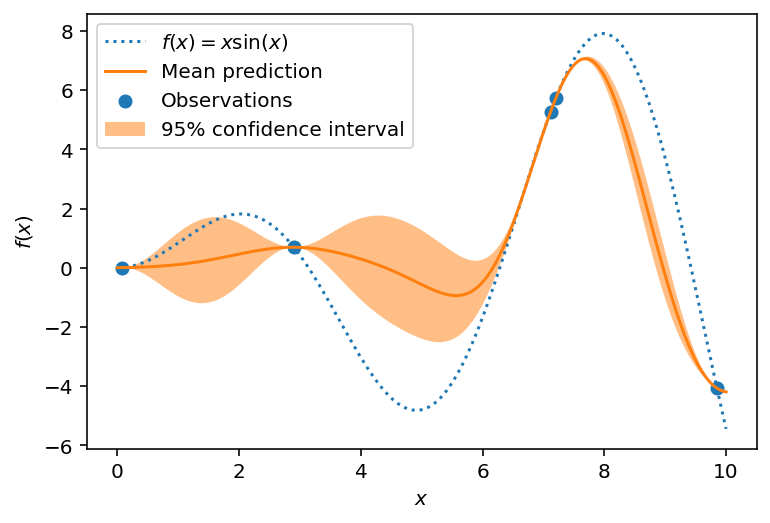

In [23]:
plt.plot(X_test, X_test*np.sin(X_test), label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X_test, mean_pred, label="Mean prediction")
plt.fill_between(
    X_test.ravel(),
    mean_pred - 1.96 * std_pred,
    mean_pred + 1.96 * std_pred,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.show()

## 3D example

Now we define a bivariate function $g(x, y) = x \sin(\frac{y}{x + \epsilon})$ where $\epsilon$ is a small constant to avoid division by zero.

In [24]:
def g(X):
    return X[:, 0] * np.sin(X[:, 1] / (X[:, 0] + 1e-6))

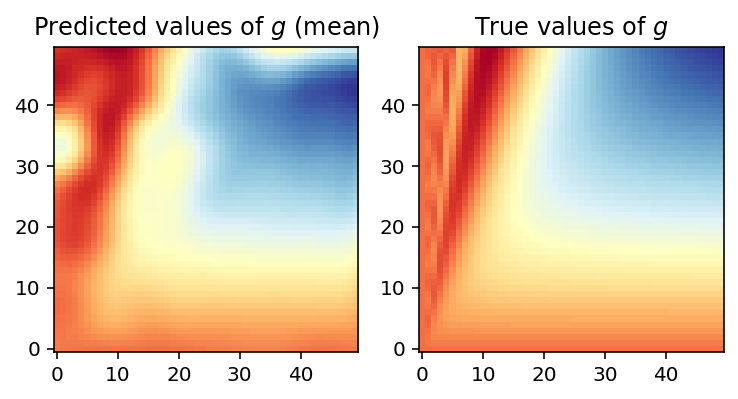

In [25]:
# Sample 100 (x, y) training points and compute target value for each using function g
X_train = np.random.uniform(low=[0,0], high=[10,10], size=(100, 2))
y_train = g(X_train)

# Compute 50x50 meshgrid from 0 to 10 along both x and y axes. These are our test points.
X_test = np.linspace(start=0, stop=10, num=50)
X_test = np.meshgrid(X_test, X_test)
xs = X_test[0].reshape(-1, 1)
ys = X_test[1].reshape(-1, 1)
X_test = np.hstack((xs, ys))

# Use the RBF kernel again
kernel = rbf(amplitude=1, length=1)

# Fit the GP to the training points and return predictions. Note that this will take longer than before.
mean_pred, std_pred = gaussian_process(X_train, y_train, X_test, kernel)

# Compute the true function values for all test points
y_true = g(X_test)

# Plot heat map of predicted function (mean only) vs. true function

im_pred = mean_pred.reshape(50, 50)
im_true = y_true.reshape(50, 50)

_, ax = plt.subplots(1, 2)
ax[0].imshow(im_pred, cmap="RdYlBu", origin="lower")
ax[0].set_title("Predicted values of $g$ (mean)")
ax[1].imshow(im_true, cmap="RdYlBu", origin="lower")
ax[1].set_title("True values of $g$")

plt.show()